In [1]:
%pip install scipy pandas numpy matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.


In [11]:
import pandas as pd
from scipy.stats import pearsonr

df = pd.read_csv('/workspaces/ticket-heroes/ticket-prophet/data/processed/FINAL_comprehensive_artists.csv') 

# Define the Target
TARGET_VARIABLE = 'avg_secondary_price' 

# Drop target variables and numerical
numerical_features = df.select_dtypes(include=['number']).columns.tolist()
if TARGET_VARIABLE in numerical_features:
    numerical_features.remove(TARGET_VARIABLE)

# Store as a tuple
correlation_results = []

for feature in numerical_features:
    temp_df = df[[feature, TARGET_VARIABLE]].dropna()

    if len(temp_df) > 1:
        # pearsonr returns (correlation_coefficient, p_value)
        correlation_coeff, p_value = pearsonr(temp_df[feature], temp_df[TARGET_VARIABLE])
        correlation_results.append((feature, correlation_coeff))
    else:
        # Handle features with too few non-null data points
        correlation_results.append((feature, 0.0)) 

# New DF
corr_df = pd.DataFrame(correlation_results, columns=['Feature', 'Correlation_r'])

# Calculate the absolute correlation for ranking importance
corr_df['Abs_Correlation'] = corr_df['Correlation_r'].abs()

# Sort by Desc
ranked_features = corr_df.sort_values(by='Abs_Correlation', ascending=False).reset_index(drop=True)

print(f"### Top 20 Features Ranked by Pearson Correlation to {TARGET_VARIABLE} ###")
print(ranked_features.head(20))

# Select for model
N = 15
top_N_features = ranked_features.head(N)['Feature'].tolist()

print(f"\n--- Selected Top {N} Features ---")
print(top_N_features)

### Top 20 Features Ranked by Pearson Correlation to avg_secondary_price ###
                    Feature  Correlation_r  Abs_Correlation
0    avg_daily_price_change       0.722475         0.722475
1          num_years_active       0.686186         0.686186
2           avg_price_range       0.510540         0.510540
3      premium_pricing_rate       0.433207         0.433207
4   github_avg_advance_days      -0.256282         0.256282
5      avg_price_volatility      -0.180558         0.180558
6        avg_track_duration      -0.165406         0.165406
7        plays_per_listener       0.160375         0.160375
8          artist_followers       0.159331         0.159331
9      github_total_tickets      -0.152703         0.152703
10         high_demand_rate       0.131154         0.131154
11             total_tracks       0.123803         0.123803
12         github_avg_price       0.119815         0.119815
13     high_volatility_rate      -0.114468         0.114468
14        artist_popula

/tmp/ipykernel_198946/1696422177.py:22: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation_coeff, p_value = pearsonr(temp_df[feature], temp_df[TARGET_VARIABLE])


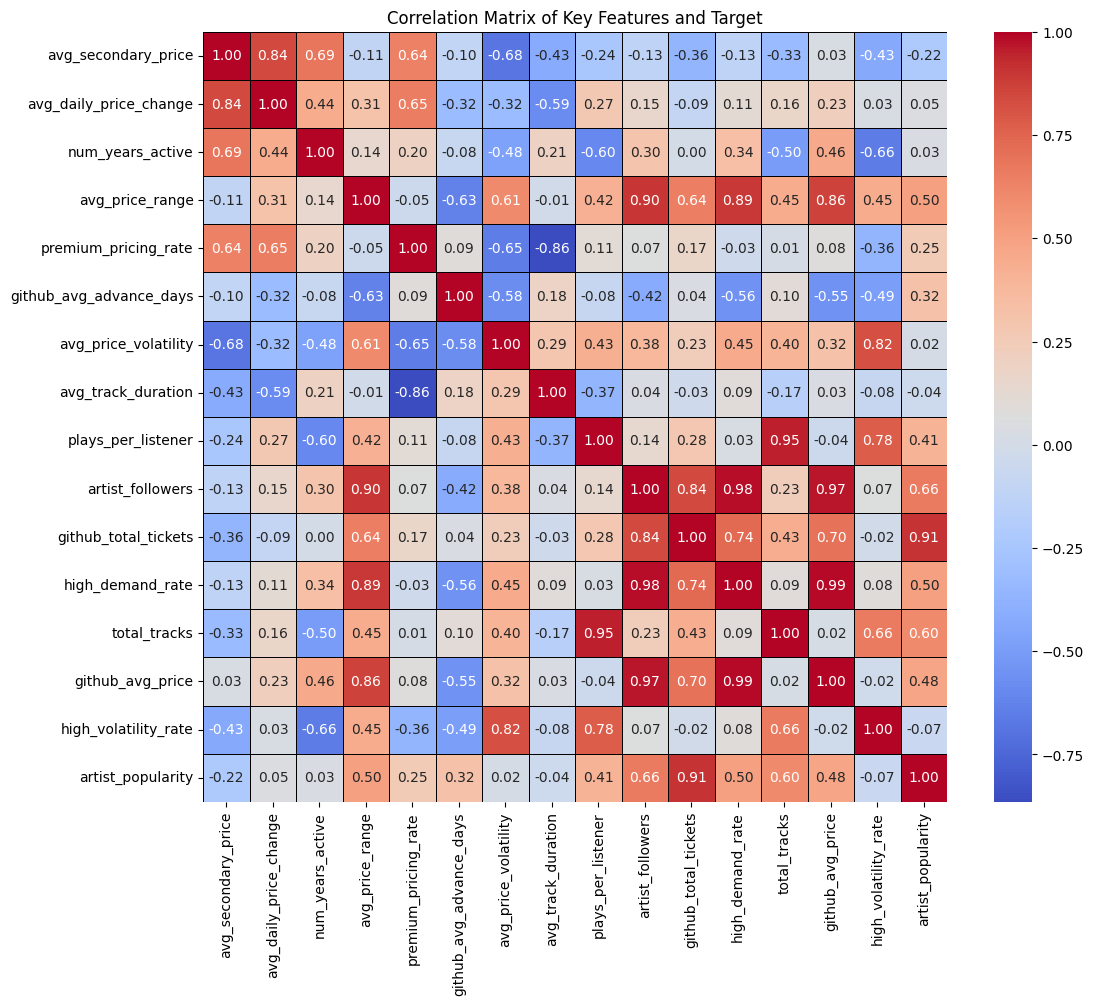


### High Correlation Check (Multicollinearity) ###
Feature pairs with high correlation (potential multicollinearity):
github_avg_price        high_demand_rate        0.986806
high_demand_rate        artist_followers        0.978577
github_avg_price        artist_followers        0.966252
total_tracks            plays_per_listener      0.953944
artist_popularity       github_total_tickets    0.912220
artist_followers        avg_price_range         0.898495
high_demand_rate        avg_price_range         0.892268
github_avg_price        avg_price_range         0.862392
github_total_tickets    artist_followers        0.841423
avg_daily_price_change  avg_secondary_price     0.840778
high_volatility_rate    avg_price_volatility    0.821891
avg_track_duration      premium_pricing_rate   -0.864553
dtype: float64


In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


TARGET_VARIABLE = 'avg_secondary_price' 


top_N_features = ranked_features.head(N)['Feature'].tolist()


key_columns_to_include = [TARGET_VARIABLE] + top_N_features


df_matrix = df[key_columns_to_include].copy().dropna() # Drop NaN for clean calculation

# The .corr() method calculates the Pearson 'r' matrix by default.
correlation_matrix = df_matrix.corr(method='pearson')


# 4. Visualize the Correlation Matrix using a Heatmap
plt.figure(figsize=(12, 10))

# 'cmap='coolwarm'' to show both positive and negative correlations.
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    cbar=True, 
    linewidths=.5, 
    linecolor='black'
)
plt.title('Correlation Matrix of Key Features and Target')
plt.show() 


# Check for Multicollinearity
print("\n### High Correlation Check (Multicollinearity) ###")
# Find pairs of features (excluding the target) with a correlation > 0.8 (or your chosen threshold)

high_corr_threshold = 0.8
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)

highly_correlated_pairs = upper_triangle.unstack().sort_values(ascending=False)
highly_correlated_pairs = highly_correlated_pairs[highly_correlated_pairs.abs() >= high_corr_threshold]

if highly_correlated_pairs.empty:
    print("No highly correlated feature pairs found (r >= 0.8).")
else:
    print("Feature pairs with high correlation (potential multicollinearity):")
    print(highly_correlated_pairs)